In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
file_path = '/content/drive/My Drive/Colab Notebooks/dl-albanian/AlbAna-simplified.csv'

# Load the CSV file into a DataFrame
df = pd.read_csv(file_path, header=0)

In [3]:
print(df.head())
num_rows, num_cols = df.shape
print("Number of rows:", num_rows)
print("Number of columns:", num_cols)

                                             Comment  Annotation
0                                     Dorentina TBT            0
1  Mbyllni kufijte sot. Sitiata ka me u ba shume ...           2
2  Mbyllni kufit ashtu mund te jemi te sigurte, p...           0
3  Pse nuk po  i  mbyllni  kufijte,  sonte  ne  q...           0
4  Mos  harroni  qe  kufinjte  tane  jane  te  ha...           0
Number of rows: 10742
Number of columns: 2


In [4]:
#Create lists of Annotations and Comments
#==============================================================================
y, docs = [], []

for annotation in df['Annotation']:
    # Append each annotation value to the list
    y.append(annotation)

for comment in df['Comment']:
    # Append each comment to the list
    docs.append(comment)

average = sum(len(doc) for doc in docs) / len(docs)
print (average)


84.7819772854217


In [5]:
#Encode class values as integers
#==============================================================================
from sklearn.preprocessing import LabelEncoder
from keras import utils

encoder = LabelEncoder()

encoder.fit(y)

encoded_y = encoder.transform(y)

# convert integers to dummy variables (i.e. one hot encoded)
if encoded_y.size == 0:
    print("Error: encoded_y is empty. Please check the input data.")
else:
    dummy_y = utils.to_categorical(encoded_y)

In [6]:
#Define plot_history function
#==============================================================================
import matplotlib.pyplot as plt

def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]

    if len(loss_list) == 0:
        print('Loss is missing in history')
        return

    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)

    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))

    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [7]:
#plot confusion_matrix function
#==============================================================================
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title='Normalized confusion matrix'
    else:
        title='Confusion matrix'

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


In [8]:
#Define full_multiclass_report which prints classification report
# updated
#==============================================================================
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def full_multiclass_report(model, x, y_true, classes, batch_size=64, binary=False):
    # 1. Transform one-hot encoded y_true into their class number
    if not binary:
        y_true = np.argmax(y_true, axis=1)

    # 2. Predict probabilities for each class
    y_pred_prob = model.predict(x, batch_size=batch_size)

    # 3. Convert predicted probabilities to class labels
    y_pred = np.argmax(y_pred_prob, axis=1)

    # 4. Print accuracy score
    print("Accuracy : " + str(accuracy_score(y_true, y_pred)))
    print("")

    # 5. Print classification report
    print("Classification Report")
    print(classification_report(y_true, y_pred, digits=4))

    # 6. Plot confusion matrix
    cnf_matrix = confusion_matrix(y_true, y_pred)
    print(cnf_matrix)
    plot_confusion_matrix(cnf_matrix, classes=classes)


In [9]:
#Input parameters
#==============================================================================
MAX_SEQUENCE_LENGTH = 20
MAX_NB_WORDS = 2000
EMBEDDING_DIM = 300

In [10]:
#Create a tokenizer
#==============================================================================
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(nb_words=MAX_NB_WORDS, lower=True )

tokenizer.fit_on_texts(docs)

sequences = tokenizer.texts_to_sequences(docs)

word_index = tokenizer.word_index

print('Found %s unique tokens.' % len(word_index))

# convert text to sequence of tokens and pad them to ensure equal length vectors
x = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/text.py:246: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn(


Found 22587 unique tokens.


In [11]:
#Training, testing and validation
#==============================================================================
from sklearn.model_selection import train_test_split
seed =1000

x_train, x_test, y_train, y_test = train_test_split(x, dummy_y, train_size=0.7, random_state=seed)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.7, random_state=seed)

In [ ]:
# No imported embeddings here

In [12]:
!pip install keras_self_attention

  Preparing metadata (setup.py) ... done
  Created wheel for keras_self_attention: filename=keras_self_attention-0.51.0-py3-none-any.whl size=18894 sha256=3f7274752b68827f431063dc0877490049bd55242b0069e13bfac68f0b9fd492
  Stored in directory: /root/.cache/pip/wheels/b8/f7/24/607b483144fb9c47b4ba2c5fba6b68e54aeee2d5bf6c05302e
Successfully built keras_self_attention


In [13]:
#Build LSTM model
#==============================================================================
from tensorflow import keras
from keras import layers, activations
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, LSTM,  SpatialDropout1D
from keras.layers import Input, Flatten, Lambda, Dropout
from keras.layers import TimeDistributed, Bidirectional
from keras_self_attention import SeqSelfAttention

model = Sequential()

'''
model.add(layers.Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False))
'''
model.add(layers.Embedding(len(word_index),  EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))




model.add(SpatialDropout1D(0.3))

model.add(Bidirectional(LSTM(32, return_sequences=True)))

model.add(SeqSelfAttention( attention_width=8, attention_activation='sigmoid', name='Attention',))

model.add(Flatten())

model.add(Dense(3, activation='softmax'))


model.summary()



model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])



/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 300)           6776100   
                                                                 
 spatial_dropout1d (Spatial  (None, 20, 300)           0         
 Dropout1D)                                                      
                                                                 
 bidirectional (Bidirection  (None, 20, 64)            85248     
 al)                                                             
                                                                 
 Attention (SeqSelfAttentio  (None, 20, 64)            4161      
 n)                                                              
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                        

Epoch 1/5
21/21 [==============================] - 9s 194ms/step - loss: 0.9654 - accuracy: 0.5681 - val_loss: 0.9234 - val_accuracy: 0.5833
Epoch 2/5
21/21 [==============================] - 3s 138ms/step - loss: 0.8459 - accuracy: 0.6302 - val_loss: 0.8030 - val_accuracy: 0.6259
Epoch 3/5
21/21 [==============================] - 3s 130ms/step - loss: 0.6443 - accuracy: 0.7361 - val_loss: 0.6864 - val_accuracy: 0.7128
Epoch 4/5
21/21 [==============================] - 2s 109ms/step - loss: 0.4840 - accuracy: 0.8077 - val_loss: 0.6969 - val_accuracy: 0.7221
Epoch 5/5
21/21 [==============================] - 2s 102ms/step - loss: 0.4136 - accuracy: 0.8429 - val_loss: 0.7407 - val_accuracy: 0.7212


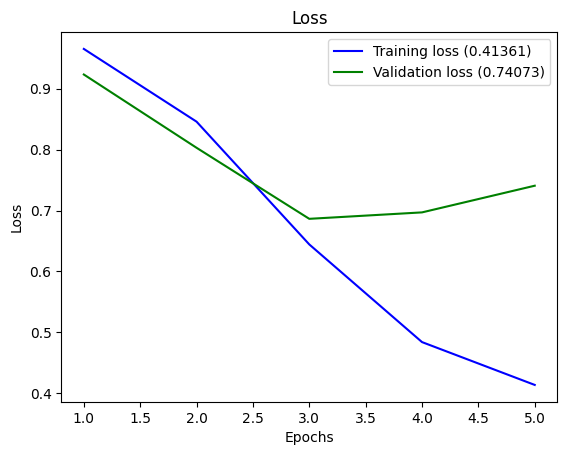

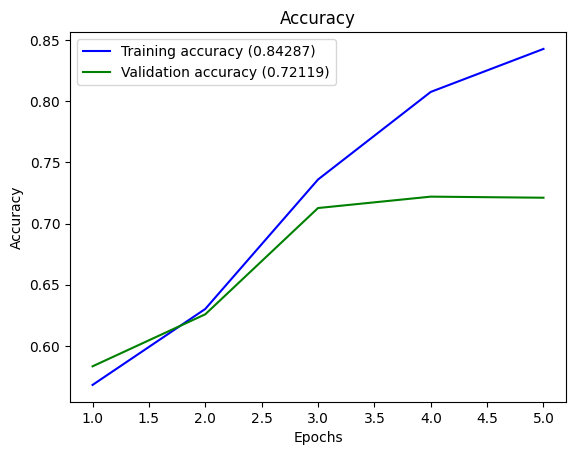

36/36 [==============================] - 1s 9ms/step
Accuracy : 0.7211879432624113

Classification Report
              precision    recall  f1-score   support

           0     0.7313    0.8541    0.7879      1268
           1     0.7715    0.5754    0.6592       358
           2     0.6654    0.5365    0.5940       630

    accuracy                         0.7212      2256
   macro avg     0.7227    0.6553    0.6804      2256
weighted avg     0.7192    0.7212    0.7133      2256

[[1083   46  139]
 [ 121  206   31]
 [ 277   15  338]]


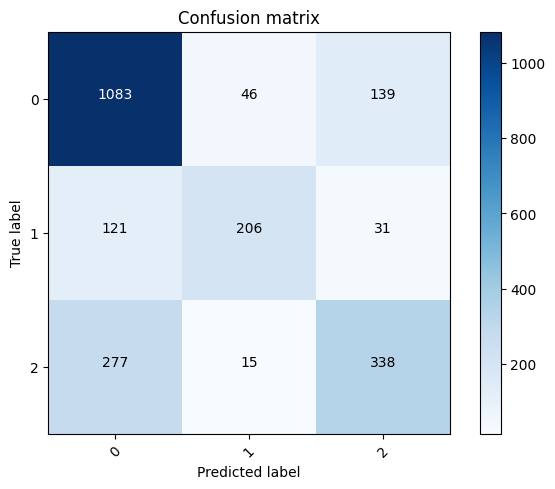

In [14]:
#Evaluate model and print results
#==============================================================================

CNN_History=model.fit(x_train, y_train, epochs = 5, batch_size = 256,verbose=1, validation_data=(x_val,y_val), shuffle=True)

plot_history(CNN_History)

full_multiclass_report(model, x_val, y_val, encoder.inverse_transform(np.arange(3)))


Architecture adapted and database sourced from: https://github.com/lule-ahmedi/AlbAna/